In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [106]:
import numba
from numba import njit


In [132]:
@njit(fastmath=True, locals={'val':numba.float32, 'tot_samps_dispersed':numba.int16})
def make_pure_frb(nsamps, nch, tx, dm, fchans, chw_2, tpulse):
    x = np.empty((nch, nsamps), dtype=np.float32)
    fbottom = fchans[0] - chw_2
    ftop = fchans[-1] + chw_2
    
    '''
    max_dm_smear = (fbottom**-2 - (fbottom+chw_2*2)**-2) / (fbottom**-2 - ftop**-2) * dm
    ux_nsamps = int(np.abs(max_dm_smear)) * 4
    ux = np.empty((nch, nsamps), dtype=np.float32)
    ux_loc = ux_nsamps // 2
    '''
    tot_samps_dispersed = 0
    
    for ii in range(nch):
        ftop_i = fchans[ii] + chw_2
        fbottom_i = fchans[ii] - chw_2
        
        cff_until_now = (fbottom**-2 - fbottom_i**-2) / (fbottom**-2 - ftop**-2)
        delta_dm = dm * cff_until_now
        tend = tpulse - delta_dm
        tend_int = int(tend)
        tend_frac = tend - tend_int
        
        
        cff_i = (fbottom_i**-2 - ftop_i**-2) / (fbottom**-2 - ftop**-2)
        dm_i = cff_i * dm
        tstart = tend - dm_i
        tstart_int = int(tstart)
        tstart_frac = 1- (tstart - tstart_int)
        
        fluence = tx
        if tstart_int == tend_int:
            frac_val_tstart = fluence
            full_samps = 0
            
        else:
            full_samps = tend_int - (tstart_int + 1)
            frac_val_tstart = tstart_frac / dm_i * fluence
            frac_val_tend = tend_frac / dm_i * fluence
            full_samp_val = fluence * (1 / dm_i)
        
        for jj in range(nsamps):
            if jj == tstart_int:
                val = frac_val_tstart
                tot_samps_dispersed = tot_samps_dispersed + 1
            elif jj == tend_int:
                val = frac_val_tend
                tot_samps_dispersed = tot_samps_dispersed + 1
            elif (jj > tstart_int) and (jj < tend_int):
                val = full_samp_val
                tot_samps_dispersed = tot_samps_dispersed + 1
            else:
                val = 0
                
            x[ii, jj] = val

        #print(f"chan {ii}, {tstart} {tend}")
        #print(x[ii])
    #x[:, :] = 0
    #x[:, nsamps//2] = 10000
    return x, tot_samps_dispersed

In [159]:
nch = 256
fchans = np.linspace(1200.5, 1455.5, nch, endpoint=True, dtype=np.float32)
chw_2 = 0.5
nsamps = 1000
tpulse = 990.5
dm = 1
tx = 10000
x, tot_samps_added = make_pure_frb(nsamps, nch, tx, dm, fchans, chw_2, tpulse)
#%timeit make_pure_frb(nsamps, nch, tx, dm, fchans, chw_2, tpulse)

<IPython.core.display.Javascript object>


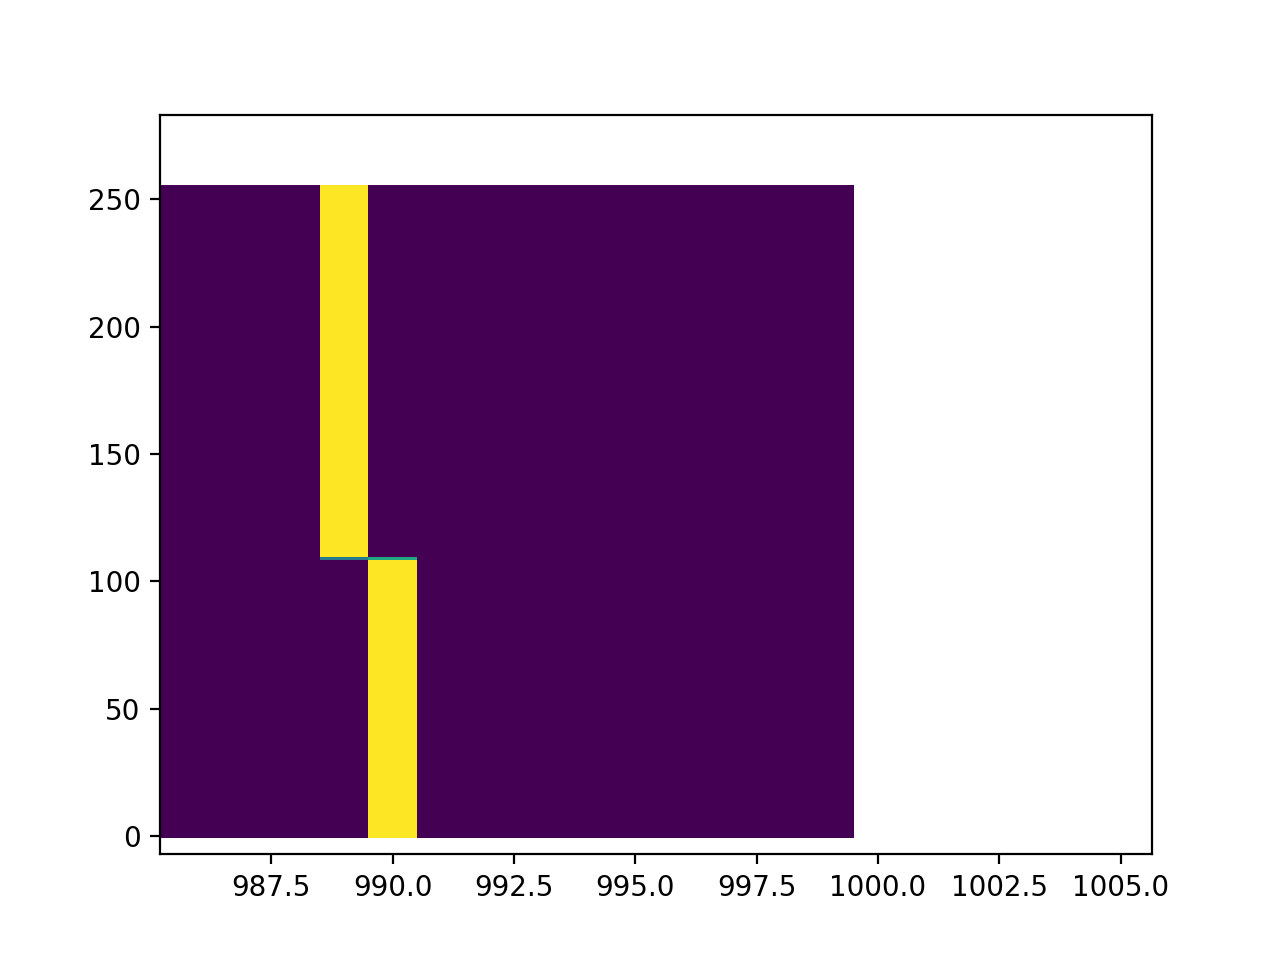

In [160]:
plt.figure()
plt.imshow(x, aspect='auto', interpolation='None', origin='lower')


In [161]:
tot_samps_added / nch

1.00390625

In [162]:
best_possible_snr = x.sum() / np.sqrt(tot_samps_added)

In [163]:
best_possible_snr

159688.41255726217

In [164]:
x.sum() / np.sqrt(256)

160000.0